In [1]:
import db
from IPython.core.display import display, HTML
import logic
import matplotlib.pyplot as plt
import pandas as pd
from numpy.random import normal
import nltk
%matplotlib nbagg


# Drugs and Fake IDs: Data Mining The Dark Web
<hr>

This Jupyter Notebook belongs to a data mining project takign place at UEL. The aim of this research is to monitor a selection of dark web resources to gain insights regarding the type of products and services that are sold, and to possibly identify any significant trends.

On the summer of 2015, a web crawling script was run over a dark web hosted e-commerce platform, collecting records of products being sold on the site. The purpose of this notebook is to analyse the data collected.
## 1. Introduction
 
### Database schema:
Figures below describe the schema of the given database

In [4]:
db.pandas_query('SHOW tables;')

,Tables_in_dark_web
0,tblCategory
1,tblProduct
2,tblSubCategory
3,tblVendor
4,tblWebsite


<hr />
##### Data definition can be obtained by the following query. Replace the table name for any of the above

In [3]:
db.pandas_query('DESCRIBE tblProduct;')

,Field,Type,Null,Key,Default,Extra
0,product_id,int(20),NO,PRI,None,auto_increment
1,product_model,varchar(200),NO,UNI,None,
2,product_name,varchar(100),NO,,None,
3,product_description,text,NO,,None,
4,product_origin,varchar(50),NO,,None,
5,product_postage,varchar(50),NO,,None,
6,product_price,varchar(50),NO,,None,
7,vendor_id,int(10),NO,MUL,None,
8,subCategory_id,int(10),NO,MUL,None,
9,time_stamp,date,NO,,None,


## 2. Market Activity Analysis

Perhaps the first thing that comes to mind when analysing a market place is to measure its size in terms of units traded,
product taxonomy, trade value, overall value etc.

These data set has been collected during the following date range:


In [4]:
db.pandas_query('''
    SELECT min(time_stamp) as 'Start Date', max(time_stamp) as 'End Date' FROM tblProduct;
    ''')

,Start Date,End Date
0,2015-07-22,2015-09-03


Within this time, the following number of records have been collected:

In [5]:
db.pandas_query('''
    SELECT count(*) as 'Total Product Records' FROM tblProduct;
    ''')

,Total Product Records
0,30680


<hr>



### 2.1 Product Categories

The site divides the product listing into a number of categories and subcategories. We will now have a look at those categories and see which products are the most popular in this particular site.

<IPython.core.display.Javascript object>


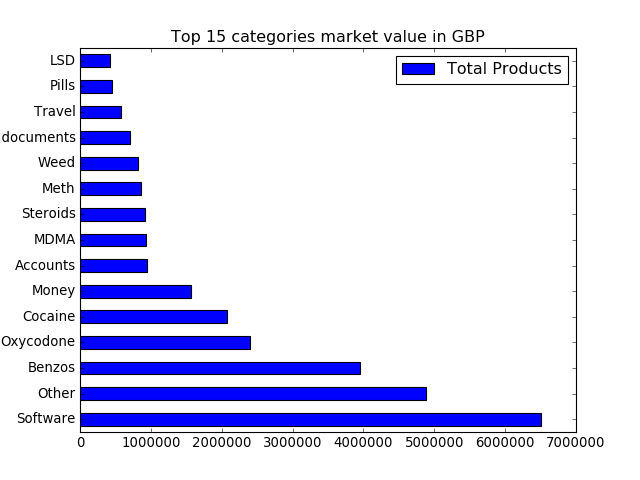

In [8]:

dataframe = db.pandas_query('''
        SELECT B.subcategory_name, count(A.product_name) as 'Total Products' 
        FROM tblProduct A
        LEFT JOIN tblSubCategory B
            ON A.subCategory_id = B.subCategory_id
        GROUP BY B.subcategory_name
        ORDER BY -count(A.product_name)
        limit 30;
        ''',
        index_col='subcategory_name')
dataframe.plot(kind='barh', title='Most Popular Categories')



From the above query we find that 20 out the 30 most common subcategories are drug related. The other main area of research we are interested on is the illegal market of passports and ids. While there seems not to be any trace of those sub categories, we yet have to analyse the "Other" subcategory.

Let's find out what percentage of these listings do actually fall in the drugs category.


   drug_listings  other
0          20849   4440


<IPython.core.display.Javascript object>


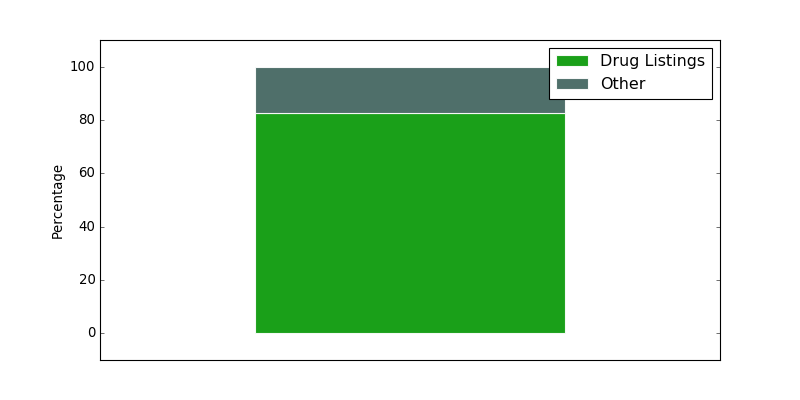

In [24]:


comparison_df = db.pandas_query('''
    SELECT count(*) as 'drug_listings' FROM tblProduct
    WHERE subCategory_id in
        (SELECT subCategory_id from tblSubCategory where subCategory_name IN
            ('2C', '5-MeO', 'Barbiturates', 'Benzos', 'Buprenorphine', 'Cannabis', 'Chemicals', 'Cocaine', 
            'Codeine', 'Concentrates', 'Containers', 'Dihydrocodeine', 'Dissociatives', 'DMT', 'Doomsday', 
            'Drugs', 'Ecstasy', 'Edibles', 'Fentanyl', 'Filters', 'Fireworks', 'GBL', 'GHB', 'Grinders', 
            'Hash', 'Heroin', 'Hydrocodone', 'Hydromorphone', 'Injecting equipment', 'Ketamine', 'LSD', 'MDA', 
            'MDMA', 'Mephedrone', 'Mescaline', 'Meth', 'Morphine', 'Mushrooms', 'MXE', 'NB', 'Needles', 'Opioids', 
            'Opium', 'Oxycodone', 'Paper', 'Paraphernalia', 'PCP', 'Pills', 'Pipes', 'Prescription', 'Psychedelics', 
            'RCs', 'Salvia', 'Scales', 'Science', 'Seeds', 'Shake/trim', 'Smoked', 'Speed', 'Spores', 'Stashes', 
            'Steroids', 'Stimulants', 'Synthetics', 'Syringes', 'Weed', 'Weight loss')
        ); 
    ''')

comparison_df['other'] = dataframe.sum()[0] - comparison_df.iloc[0][0]
print (comparison_df)

# Create a figure with a single subplot
f, ax = plt.subplots(1, figsize=(10,5))
bar_width = 1

# positions of the left bar-boundaries
bar_l = [i for i in range(len(comparison_df['drug_listings']))] 

# positions of the x-axis ticks (center of the bars as bar labels)
tick_pos = [i+(bar_width/2) for i in bar_l] 

# Create the total
totals = [i+j for i,j in zip(comparison_df['drug_listings'], comparison_df['other'])]

# Create the percentage
pre_rel = [i / j * 100 for  i,j in zip(comparison_df['drug_listings'], totals)]
mid_rel = [i / j * 100 for  i,j in zip(comparison_df['other'], totals)]

# Create a bar chart in position bar_1
ax.bar(bar_l, 
       pre_rel, 
       label='Drug Listings', 
       alpha=0.9, 
       color='#019600',
       width=bar_width,
       edgecolor='white'
       )
ax.bar(bar_l, 
       mid_rel, 
       bottom=pre_rel,  
       label='Other', 
       alpha=0.9, 
       color='#3C5F5A', 
       width=bar_width,
       edgecolor='white'
       )



# Set the ticks to be first names
ax.set_ylabel("Percentage")
ax.set_xlabel("")
ax.get_xaxis().set_ticks([])
ax.legend()

# Let the borders of the graphic
plt.xlim([min(tick_pos)-bar_width, max(tick_pos)+bar_width])
plt.ylim(-10, 110)

# shot plot
plt.show()



## 2.2 Geografical Activity Distribution

### 2.2.1 Total Products listed by country of origin
  



<IPython.core.display.Javascript object>


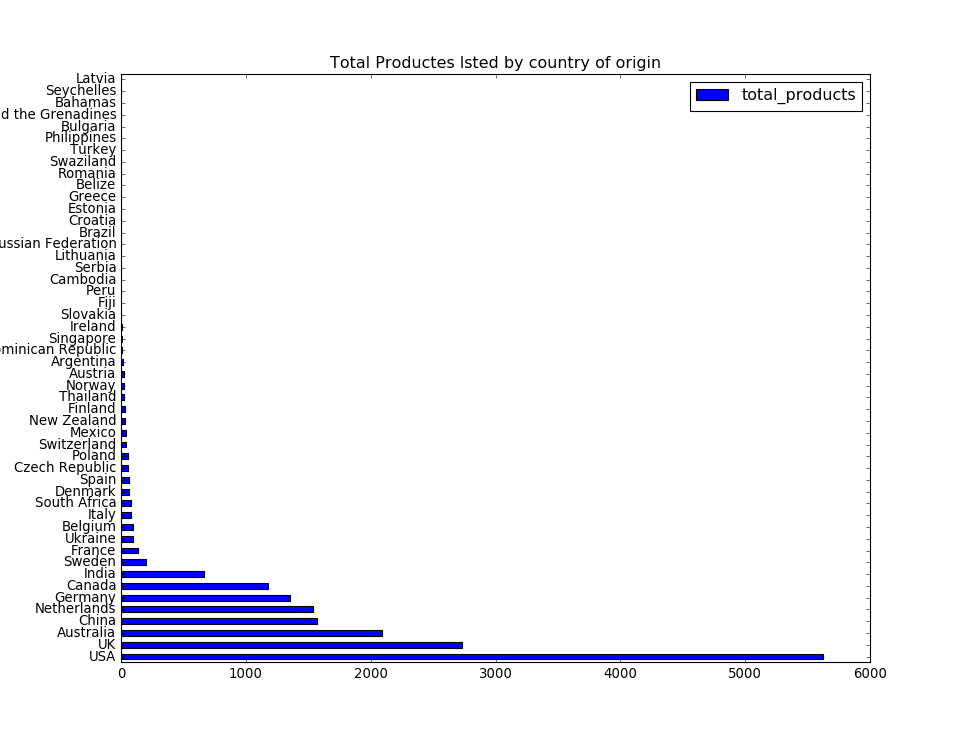

In [8]:
countries_df = db.pandas_query('''
    SELECT count(*) as 'total_products', product_origin FROM tblProduct
    WHERE product_origin != ''
    GROUP BY product_origin
    ORDER BY total_products DESC;
    ''', index_col='product_origin')

countries_df.plot(kind='barh', title='Total Productes lsted by country of origin')

### 2.2.2 Total drug listings by product country of origin.


<IPython.core.display.Javascript object>


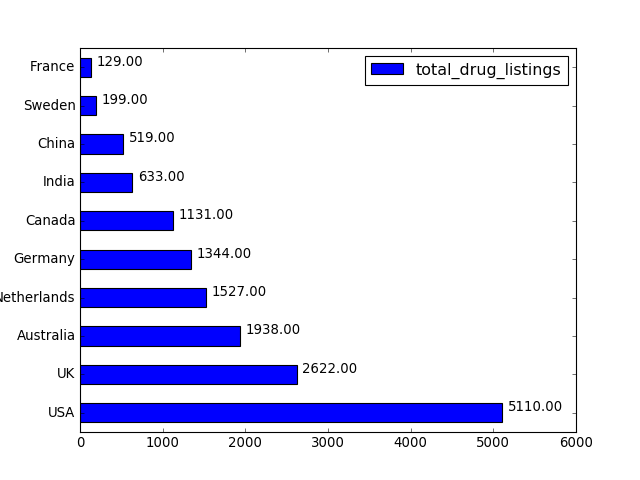

In [9]:
countries_df = db.pandas_query('''
    SELECT count(*) as 'total_drug_listings', product_origin FROM tblProduct
    WHERE product_origin != ''
    and subCategory_id in
        (SELECT subCategory_id from tblSubCategory where subCategory_name IN
            ('2C', '5-MeO', 'Barbiturates', 'Benzos', 'Buprenorphine', 'Cannabis', 'Chemicals', 'Cocaine', 
            'Codeine', 'Concentrates', 'Containers', 'Dihydrocodeine', 'Dissociatives', 'DMT', 'Doomsday', 
            'Drugs', 'Ecstasy', 'Edibles', 'Fentanyl', 'Filters', 'Fireworks', 'GBL', 'GHB', 'Grinders', 
            'Hash', 'Heroin', 'Hydrocodone', 'Hydromorphone', 'Injecting equipment', 'Ketamine', 'LSD', 'MDA', 
            'MDMA', 'Mephedrone', 'Mescaline', 'Meth', 'Morphine', 'Mushrooms', 'MXE', 'NB', 'Needles', 'Opioids', 
            'Opium', 'Oxycodone', 'Paper', 'Paraphernalia', 'PCP', 'Pills', 'Pipes', 'Prescription', 'Psychedelics', 
            'RCs', 'Salvia', 'Scales', 'Science', 'Seeds', 'Shake/trim', 'Smoked', 'Speed', 'Spores', 'Stashes', 
            'Steroids', 'Stimulants', 'Synthetics', 'Syringes', 'Weed', 'Weight loss')
        )
    GROUP BY product_origin
    ORDER BY total_drug_listings DESC
    LIMIT 10;
    ''', index_col='product_origin')

countries_ax = countries_df.plot(kind='barh')
for p in countries_ax.patches:
    countries_ax.annotate(
        "%.2f" % p.get_width(), (p.get_x() + p.get_width(), 
        p.get_y()), xytext=(5, 10), textcoords='offset points')

### HIGHLIGHTS:
 - USA has the leading position in total products sold as well as in the drugs market
 - For Most countries, drugs are by far the most common type of product
 - Interestingly, in the case of <b>China</b>, only 24% of their listed products belong to drug related subcategories
 
Given the chinese scenario, lets dive a little bit deeper and see what kind of products are attracting more attention in the Chinese Market.

<IPython.core.display.Javascript object>


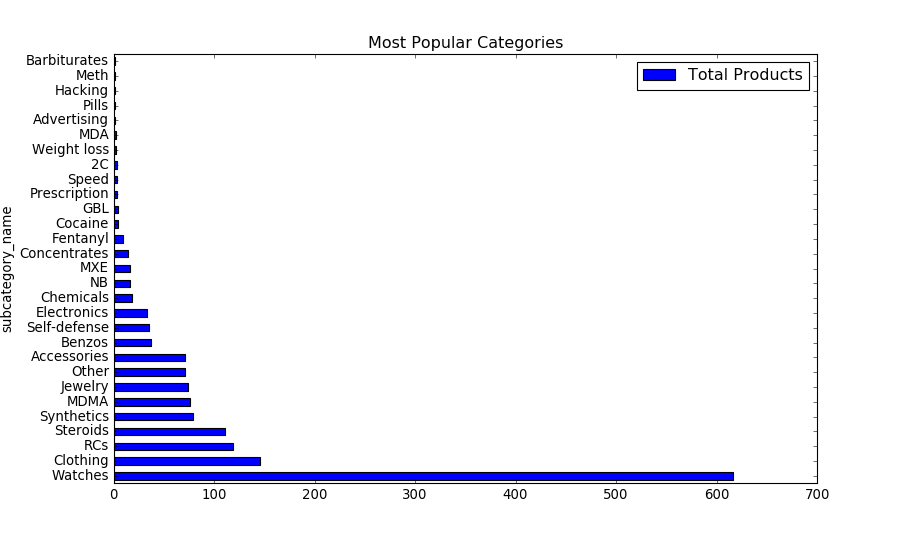

In [10]:
china_df = db.pandas_query('''
    SELECT B.subcategory_name, count(A.product_name) as 'Total Products' 
    FROM tblProduct A
    LEFT JOIN tblSubCategory B
        ON A.subCategory_id = B.subCategory_id
    WHERE product_origin = 'China'
    GROUP BY B.subcategory_name
    ORDER BY -count(A.product_name)
    limit 30;
    ''',
    index_col='subcategory_name')
china_df.plot(kind='barh', title='Most Popular Categories')

### 2.2.3 Main Drug Providers

As we have previously seen, we know that some of the most popular drugs on offer in this market place are Cocaine, weed, MDMA, LSD or Heroin. We will try to find the top three providing countries for each of these drugs

<IPython.core.display.Javascript object>


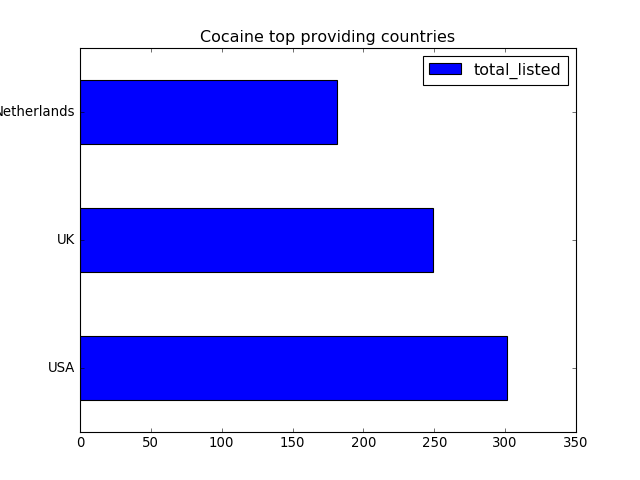

<IPython.core.display.Javascript object>


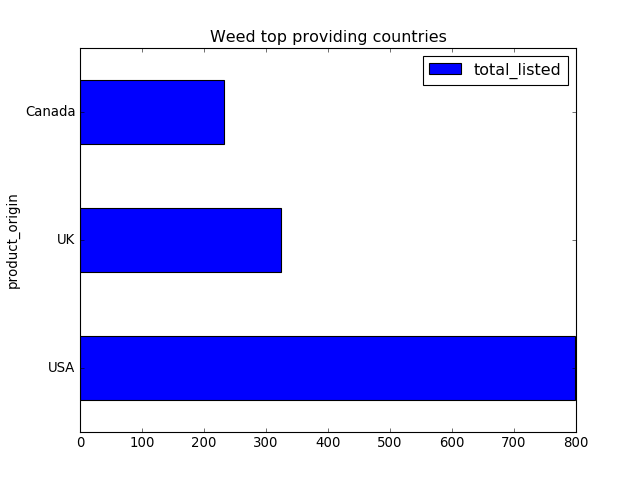

<IPython.core.display.Javascript object>


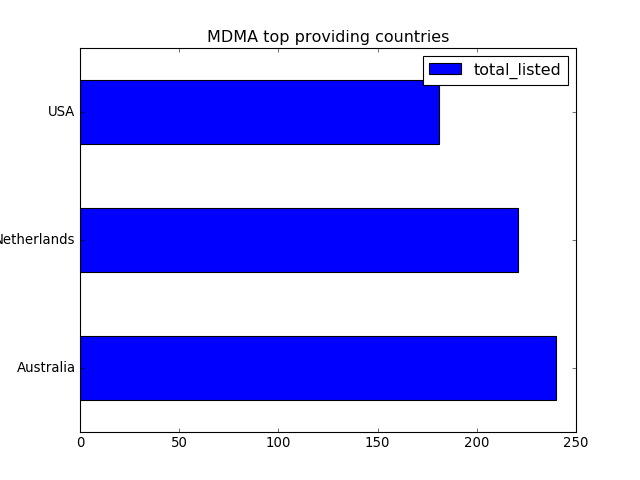

<IPython.core.display.Javascript object>


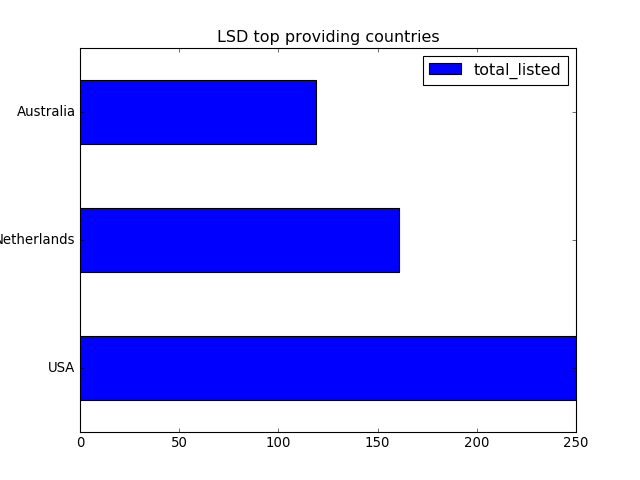

<IPython.core.display.Javascript object>


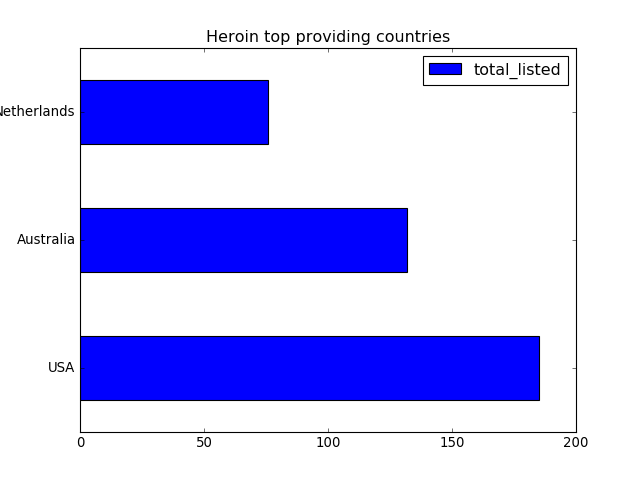

<IPython.core.display.Javascript object>


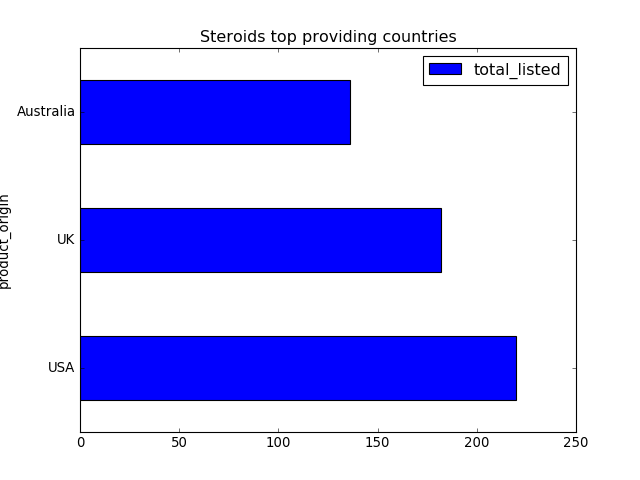

<IPython.core.display.Javascript object>


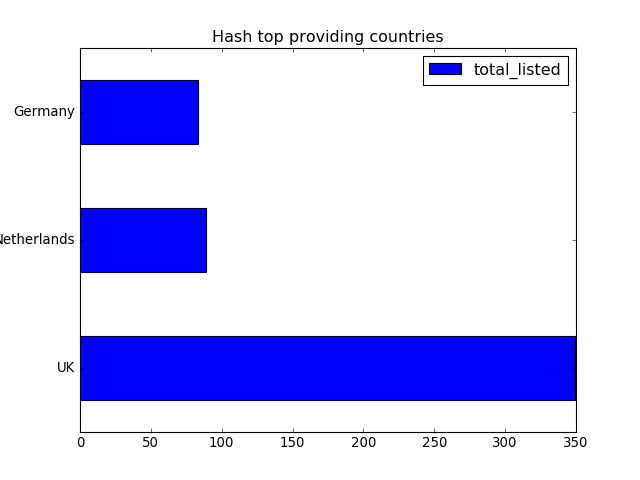

In [11]:
base_drugs_query = '''
    SELECT count(*) as 'total_listed', product_origin FROM tblProduct
    WHERE subCategory_id in (SELECT subCategory_id FROM tblSubCategory
        WHERE subCategory_name = '{}')
    AND product_origin != ''
    GROUP BY product_origin
    ORDER BY total_listed DESC
    LIMIT 3;
    '''
drugs_list = ['Cocaine', 'Weed', 'MDMA', 'LSD', 'Heroin', 'Steroids', 'Hash']
drug_data = {}
ax = None
for drug in drugs_list:
    df = db.pandas_query(base_drugs_query.format(drug), index_col='product_origin')
    df.plot.barh(title='{} top providing countries'.format(drug))


## 2.3 Time series Analysis


This section will try to understand the evolution over time of Agora's supply to find out growth rates in terms of total offerings as well as in the specifics of drugs.

 ### 2.3.1 Day-on-day supply analysis
 
 

<IPython.core.display.Javascript object>


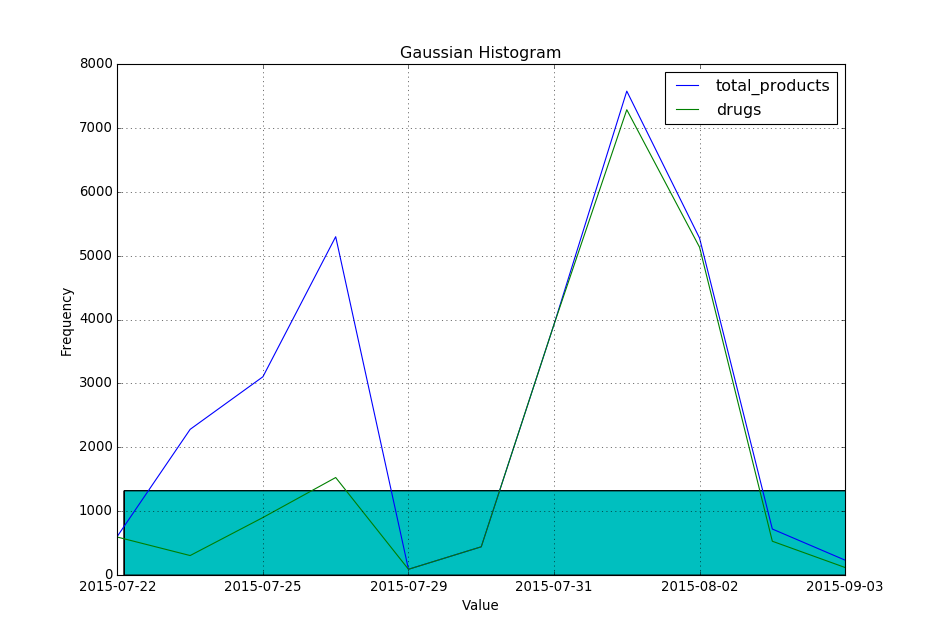

In [12]:
dayonday_df = db.pandas_query('''
    SELECT count(*) as total_products, time_stamp FROM tblProduct
    GROUP BY time_stamp;
    ''', index_col='time_stamp')
dayonday_drugs_df = db.pandas_query('''
    SELECT count(*) as drugs, time_stamp FROM tblProduct
    WHERE subCategory_id in
        (SELECT subCategory_id from tblSubCategory where subCategory_name IN
            ('2C', '5-MeO', 'Barbiturates', 'Benzos', 'Buprenorphine', 'Cannabis', 'Chemicals', 'Cocaine', 
            'Codeine', 'Concentrates', 'Containers', 'Dihydrocodeine', 'Dissociatives', 'DMT', 'Doomsday', 
            'Drugs', 'Ecstasy', 'Edibles', 'Fentanyl', 'Filters', 'Fireworks', 'GBL', 'GHB', 'Grinders', 
            'Hash', 'Heroin', 'Hydrocodone', 'Hydromorphone', 'Injecting equipment', 'Ketamine', 'LSD', 'MDA', 
            'MDMA', 'Mephedrone', 'Mescaline', 'Meth', 'Morphine', 'Mushrooms', 'MXE', 'NB', 'Needles', 'Opioids', 
            'Opium', 'Oxycodone', 'Paper', 'Paraphernalia', 'PCP', 'Pills', 'Pipes', 'Prescription', 'Psychedelics', 
            'RCs', 'Salvia', 'Scales', 'Science', 'Seeds', 'Shake/trim', 'Smoked', 'Speed', 'Spores', 'Stashes', 
            'Steroids', 'Stimulants', 'Synthetics', 'Syringes', 'Weed', 'Weight loss')
        )
    GROUP BY time_stamp;
    ''', index_col='time_stamp')
dayonday_df2 = pd.concat([dayonday_df, dayonday_drugs_df], axis='time_stamp', join='inner')
dayonday_df2.plot()

<hr>
Unfortunately, we can't analyse this market growth over time, as there are not enough data points. The growth of the drugs market share over time seems to be also unbearable for the same reason.

# 3. Market quantitative analysis

The currency used in this dark web hosted commerce platform is the Bitcoin. The dataset does contain the bitcoin price at which each listing has been placed, however, Bitcoin exchange rates are very volatile. Therefore, it would be meaningless to analyse the dataset in terms of its bitcoin value. Instead, each of the Bitcoin values have been converted to both GBP and USD as of the market exchange rate as of the day the product was listed on the website.



### 3.1 Natural Language processing: Data Mining Listing quantities and measurement units
Our listings product quantites are not suitable for data analysis, as they are cotained within title and description fields which are just composed of unstructured text blocks.
In order to extract those quantities we can either manipulate the string fields with regular expressions or use Natural Language proccessing to extract the required values using semantic and grammar machine learning algorithms.
There is a powerfull NLP library called NLTK that we will use in our attempt to extract those values.
Let's look at the folliwng two title examples extracted from the 'Cocaine' subcategory dataset:
<blockquote>"6 Grams Pure Cocaine (SAFE,ZERO CUTS & PURE+FREE COKE DAILY)"</blockquote>
<blockquote>"SALE!! 28G Cocaine - 92% Purity -Platinum Quality - No Cuts FE LISTING"</blockquote>
We start by tokenizing the sentence into words and analyze the word types grammatically

In [2]:
string = "6 Grams Pure Cocaine (SAFE,ZERO CUTS & PURE+FREE COKE DAILY)"
tokenized = nltk.word_tokenize(string)
tagged = nltk.pos_tag(tokenized)
print (tagged)


[('6', 'CD'), ('Grams', 'NNP'), ('Pure', 'NNP'), ('Cocaine', 'NNP'), ('(', '('), ('SAFE', 'NNP'), (',', ','), ('ZERO', 'NNP'), ('CUTS', 'NNP'), ('&', 'CC'), ('PURE+FREE', 'NNP'), ('COKE', 'NNP'), ('DAILY', 'NNP'), (')', ')')]


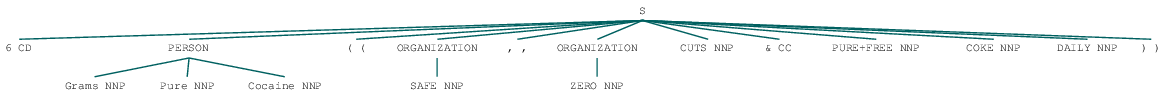

In [3]:
named_entities = nltk.ne_chunk(tagged)
named_entities


As expected, the unsupervised learning algorithm wasn't very accurate and has classified the words 'Grams Pure Cocaine' as a persons name, given that is composed of 3 capitalized words.

<p> Let's now move into the second example. </p>


In [2]:
string = "SALE!! 28G Cocaine - 92% Purity -Platinum Quality - No Cuts FE LISTING"
tokenized = nltk.word_tokenize(string)
tagged2 = nltk.pos_tag(tokenized)
tagged2

NameError: name 'nltk' is not defined

In this particular case our grammar learning has diverted from the previous example as the word tokenizing algorithm has returned the word 28G rather than "28" and "G" as separate words. As the problem has happened at the word tokenization process, let's add a regular expression check to make sure CD and unit are returned separately:

In [3]:
tokenizer_regex = r'(?u)\d+(?:\.\,\d+)?|\w+|%'
tokenized = nltk.regexp_tokenize(string, tokenizer_regex)
tagged3 = nltk.pos_tag(tokenized)
tagged3

NameError: name 'nltk' is not defined


The regular expression based tokenizer has worked better, as it does now effectively split the unit from it's numerical value. The unit though is being classified as a proper noun (NNP) instead of a nount (NN) as the word is capitalized.
Finally, we can "chunk" the POS tags using a POS regex match to get those pairs

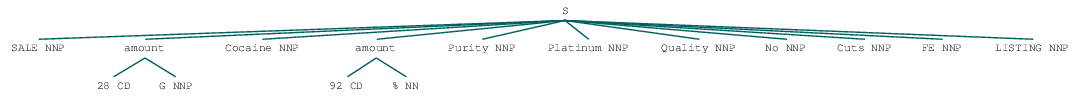

In [7]:
chunk_exp = r'''amount: {<CD><NN|NNP|NNS|NNPS>}'''
chunk_parser = nltk.RegexpParser(chunk_exp)
chunked = chunk_parser.parse(tagged3)
chunked

In [ ]:
chunked.draw()

### 3.1.1 Applying NLP to obtain Cocaine prices per gram

We want now to tune and refine the algorithm to fit our dataset. This code must be available to be used whenever we need to data mine values with a similar structure to the cocaine subset.

The following pair of functions will work as generators that an be applied to a series object:

In [2]:
def amount_series_generator(chunk, unit):
    """
    function that yields measurment units from a given chunk
    """
    valid_units = logic.VALID_UNITS.get(unit)
    for subtree in chunk.subtrees(filter=lambda t: t.label() == 'amount'):
        leaves = subtree.leaves()
        if leaves[1][0].lower() in valid_units:
            return float(leaves[0][0])
        #added this line as I found a few listings selling KILOS of cocaine!
        elif leaves[1][0].lower() in ['kg', 'kilo', 'kilogram', 'kgram']:
            return float(leaves[0][0]) * 1000
        #another hack for oz
        elif leaves[1][0].lower() in ['oz', 'ounce', 'ounces']:
            if logic.NUMBER_STRING.get(leaves[0][0].lower()):
                print(logic.NUMBER_STRING.get(leaves[0][0].lower()))
                return logic.NUMBER_STRING.get(leaves[0][0].lower()) * 28.35
            return float(leaves[0][0]) * 28.35

    return None

def unit_series_generator(chunk, unit):
    """
    function that yields measurement units from a given chunk
    """
    valid_units = logic.VALID_UNITS.get(unit)
    if unit == 'g':
        valid_units + ['kg', 'kilo', 'kilogram', 'kgram', 'oz', 'ounce', 'ounces']
    for subtree in chunk.subtrees(filter=lambda t: t.label() == 'amount'):
        leaves = subtree.leaves()
        if leaves[1][0].lower() in valid_units:
            return unit
    return None


<p> The data we want to extract is contained within the product_name field. Then, we need to process the query and then apply the previously described algorithms subsequently </p>

In [3]:

tokenizer_regex = r'(?u)\d+(?:\.\d+)?|\w+|%'
chunk_exp = r'''amount: {<CD><NN|NNP|NNS|NNPS|JJ>}'''
chunk_parser = nltk.RegexpParser(chunk_exp)
cocaine_listings = db.get_products_by_subcategory('Cocaine')
cocaine_listings_names = cocaine_listings['product_name']
cocaine_words = cocaine_listings_names.apply(nltk.regexp_tokenize, args=(tokenizer_regex,))
cocaine_tagged = cocaine_words.apply(nltk.pos_tag)
cocaine_chunked = cocaine_tagged.apply(chunk_parser.parse)

cocaine_quants = cocaine_chunked.apply(amount_series_generator, args='g')
cocaine_units = cocaine_chunked.apply(unit_series_generator, args='g')
cocaine_listings['cocaine_amount'] = cocaine_quants
cocaine_listings['cocaine_units'] = cocaine_units
cocaine_listings[['product_id', 'product_name','GBP', 'cocaine_amount', 'cocaine_units']]





AttributeError: 'module' object has no attribute 'get_products_by_subcategory'

The overview shows that the algorithms have performed as epected, but we still see some empty values still, mainly due to the lack of information on the product name.

In order to understand the success rate of the algorithms we can do:

In [14]:
failed = cocaine_units.isnull().sum()
print ('{} out of {} units obtained obtained'.format(len(cocaine_units) - failed, len(cocaine_units)))
print ('{}% success rate'.format(100-(failed/len(cocaine_units)*100)))

1169 out of 1322 units obtained obtained
88.42662632375189% success rate


As we had just a 12% failure, we can handle the Null values normalizing the distribution with the help of the standard deviation.


In [16]:
gbp_grams_df = cocaine_listings[['GBP', 'cocaine_amount']]
#remove the NaN rows to calculate mean
gbp_grams_df = gbp_grams_df[pd.notnull(gbp_grams_df['cocaine_amount'])]
gbp_grams_df['price_per_gram'] = gbp_grams_df['GBP'] / gbp_grams_df['cocaine_amount']
mean = cocaine_mean_price = gbp_grams_df['price_per_gram'].mean()
mean

95.231296329954333

And now we can use the value to fill the missing cells in our main dataframe:

In [60]:

cocaine_listings['cocaine_amount'] = cocaine_listings.cocaine_amount.fillna(cocaine_listings['GBP'] / mean)
cocaine_listings['cocaine_amount'] = cocaine_listings['cocaine_amount'].round(2)
cocaine_listings['cocaine_units'] = cocaine_listings.cocaine_units.fillna('g')
cocaine_listings['price_per_gram'] = cocaine_listings['GBP'] / cocaine_listings['cocaine_amount']
cocaine_listings




,product_id,product_model,product_name,product_description,product_origin,product_postage,product_price,vendor_id,subCategory_id,time_stamp,product_picture,USD,GBP,cocaine_amount,cocaine_units,price_per_gram
0,26564,http://agorahooawayyfoe.onion/p/AX1h9ECpFV,5 gram Pure Flakes free shipping,5 gram uncut cocaine.<br/>100% pure! (92% puri...,Netherlands,,1.05068205 BTC,729,62,2015-08-01,AX1h9ECpFV.jpg,294.23,188.34,5.00,g,37.668000
1,26565,http://agorahooawayyfoe.onion/p/iL6euvZTdG,1G Cocaine - 70% Purity - Silver Quality - ESCROW,ESCROW LISTING - 10% Cheaper on my FE Listings...,Australia,Australia,0.90821668 BTC,771,62,2015-08-01,iL6euvZTdG.jpg,254.33,162.81,1.00,g,162.810000
2,26566,http://agorahooawayyfoe.onion/p/YZm4bG64KF,5g HIGH HEAT COCAINE,5g High Heat Cocaine<br/>This listing is for H...,Canada,World,1.49944794 BTC,725,62,2015-08-01,YZm4bG64KF.jpg,419.90,268.79,5.00,g,53.758000
3,26567,http://agorahooawayyfoe.onion/p/SdVLjJymBX,Synthetic Cocaine 10g,This is new drugs - synthetic cocaine (Revers ...,Czech Republic,,1.01862734 BTC,893,62,2015-08-01,SdVLjJymBX.jpg,285.25,182.60,10.00,g,18.260000
4,26568,http://agorahooawayyfoe.onion/p/yESjSZr5Sg,28 Grams of UKWHITE&#39;S Sociable Cocaine [FL...,28 Grams of UKWHITE&#39;S Sociable Cocaine ---...,UK,WORLDWIDE,3.98903016 BTC,1058,62,2015-08-01,None,1117.08,715.07,28.00,g,25.538214
5,26569,http://agorahooawayyfoe.onion/p/nZX91dU7fv,FE - High Quality Cocaine 0.5 Grams,Welcome to CocoMarley&acute;s Nose Candy Shop!...,Dominican Republic,Worldwide,0.12465719 BTC,1059,62,2015-08-01,nZX91dU7fv.jpg,34.91,22.35,0.50,g,44.700000
6,26570,http://agorahooawayyfoe.onion/p/FA9xZ18wzi,3.5g Cocaine **PROMOTION**,***** ESCROW FOR ALL ORDERS *****<br/><br/>We ...,Germany,WORLDWIDE,0.92958649 BTC,747,62,2015-08-01,None,260.32,166.64,3.50,g,47.611429
7,26571,http://agorahooawayyfoe.onion/p/mlc5wawkEs,9 gram Pure free shipping,9 gram uncut cocaine.<br/>100% pure! (92% puri...,Netherlands,,1.89122769 BTC,729,62,2015-08-01,mlc5wawkEs.jpg,529.61,339.02,9.00,g,37.668889
8,26572,http://agorahooawayyfoe.onion/p/JDgeVUxtlm,Ching 1g Free Shipping! Buy 3 get 1 Free!,Best selling and now banned in the UK! 1g pac...,UK,"UK, EUROPE, USA",0.08191758 BTC,600,62,2015-08-01,JDgeVUxtlm.jpg,22.94,14.68,1.00,g,14.680000
9,26573,http://agorahooawayyfoe.onion/p/V0X34WR6ox,56g Highest Purity Cocaine - Direct From Colombia,Mission Statement: To provide the best quality...,USA,Worldwide,11.16928446 BTC,1060,62,2015-08-01,V0X34WR6ox.jpg,3127.81,2002.20,56.00,g,35.753571


After all this data wranglig we can effectively calculate the amount of cocaine being sold on the site as well as further analyse the data set by price and grams.

80382.39 grams on sale for 2069279.89 GBP
Average price: 95.26773128488627 GBP per gram
Median price: 57.816428571428574 GBP per gram


<IPython.core.display.Javascript object>


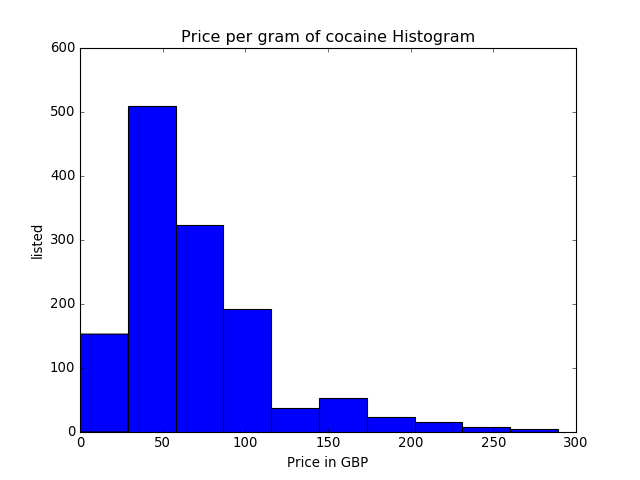

In [28]:
print ('{} grams on sale for {} GBP'.format(
        cocaine_listings['cocaine_amount'].sum(), 
        round(cocaine_listings['GBP'].sum(), 2)))
print ('Average price: {} GBP per gram'.format(cocaine_listings['price_per_gram'].mean()))
print('Median price: {} GBP per gram'.format(cocaine_listings['price_per_gram'].median()))
#cocaine_listings['price_per_gram'].hist()
cocaine_plot_df = cocaine_listings[cocaine_listings['price_per_gram'] <1000 ]
#cocaine_plot_df['price_per_gram'].hist(x)

import matplotlib.pyplot as plt
plt.hist(cocaine_plot_df['price_per_gram'], bins=10)
plt.title("Price per gram of cocaine Histogram")
plt.xlabel("Price in GBP")
plt.ylabel("listed")
plt.show()




And now we can group our results by country of origin:

<IPython.core.display.Javascript object>


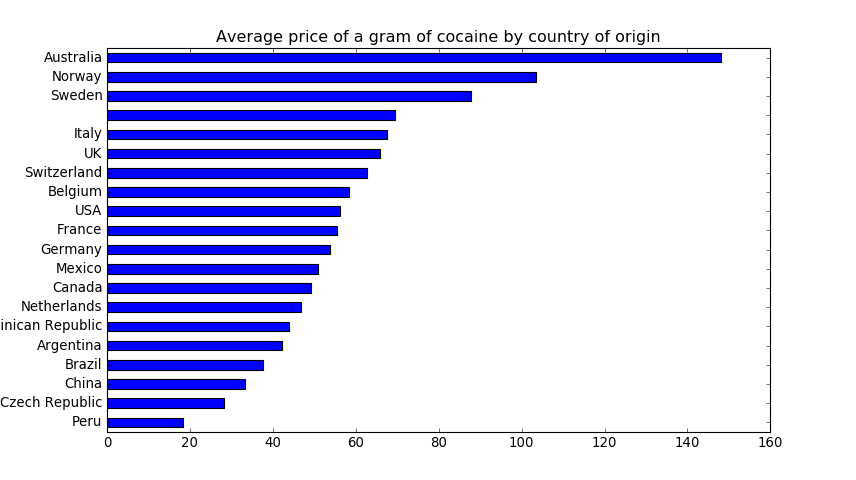

In [48]:
cocaine_plot_df.groupby('product_origin')['price_per_gram'].mean().sort_values().plot(
    kind='barh', 
    title='Average price of a gram of cocaine by country of origin')

<IPython.core.display.Javascript object>


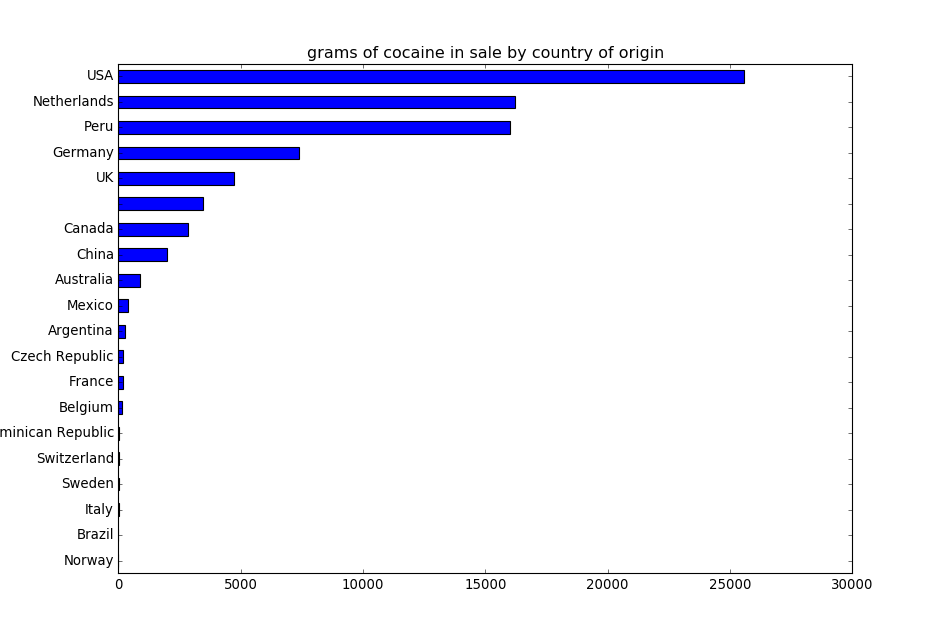

In [47]:
cocaine_plot_df.groupby('product_origin')['cocaine_amount'].sum().sort_values().plot(
    kind='barh', 
    title='grams of cocaine in sale by country of origin')

While dealing with the gaps some outliers where generated, with prices per gram orders of magnitude higher than the mean. After analyzing that sample, we discovered that some of the listings where offereing KILOGRAMS of cocaine! After tunning the NLP algorithm to also understand kilograms (and ounces) the distribution was normalized again.
<b>
The following code exposes a subset of some of those suprising listings (offering more than 500g):

In [22]:
cocaine_listings[[
        'product_id', 'product_name', 'vendor_id' ,
        'product_origin', 'GBP', 
        'cocaine_amount', 'cocaine_units']
        ][cocaine_listings['cocaine_amount'] > 500]


NameError: name 'cocaine_listings' is not defined

<b> HIGHLIGHTS </b>
 - One listing offers 10kg of cocaine
 - We can see that some vendors offer cocaine shipping from different areas of the world (possibly there could be criminal organizations behind this sales

## 3.2 Drugs market totals

With the bitcoin values added to both GBP and USD, we can rank each of the drugs in total value, which gives a better picture of the size of the market than just the activity measured by the number of products listed in the site.

In [12]:
print ('Total Market Value: {} USD'.format(db.query('''SELECT SUM(USD) from tblProduct''').fetchone()[0]))

Total Market Value: 48951430.16 USD


<IPython.core.display.Javascript object>


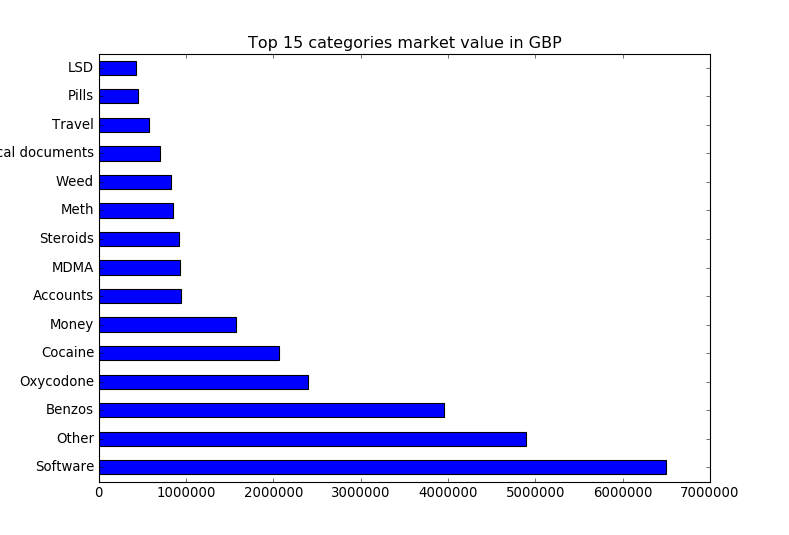

In [18]:
all_products_df = db.pandas_query('''
    SELECT product_id, GBP, B.subCategory_name FROM tblProduct 
    JOIN tblSubCategory B
    ON B.subCategory_id = tblProduct.subCategory_id;
''')

all_products_df.groupby('subCategory_name')['GBP'].sum()\
    .sort_values(ascending=False)\
    .head(15)\
    .plot(kind='barh', title = 'Top 15 categories market value in GBP',
         x='Total GBP', y='Category')

## 3.3 Illegal Documents

Up until now we have looked at the category as one single group in order to build a general picture of the market in terms of its size, its value, grographic distributions and time series.
<p>In addition, we have also dug deeper onto the drug markets in a number of ways and described in much more detail one of the most popular areas of this particular market: The cocaine market</p>

<p> In this section we are going to focus instead on the different fake and illegal documents that are available for sale in this website. More recently, this topic has been covered on the media, relating to how different interantional terrorist groups have gained access to illegal documents that allow them to travel through ultiple countries using this fake documents.</p>

### 3.3.1 Passports

We have seen records of passports on the database but we are not sure under which categories are they being labeled. Let's have a look:


In [25]:
passport_categories = db.pandas_query('''
    SELECT count(A.subCategory_id) as total_passports, B.subCategory_name FROM tblProduct A
    JOIN tblSubCategory B ON B.subCategory_id = A.subcategory_id
    WHERE A.product_name LIKE '%passport%'
    GROUP BY B.subcategory_name
    ORDER BY total_passports DESC;
    ''')
passport_categories

,total_passports,subCategory_name
0,84,Scans/Photos
1,12,Physical documents
2,5,Other
3,2,Pirated
4,1,Money


 Unfortunately there isn't a large dataset of passport items but still worth making an exploratory analysis.
<p> After manually revising the databse entries I have learned that those passports under the only two categories containning fake passports are the following:
 - Physical documents: Fake passports are on offer, the vendors claim that they will be accepted by the authorities as real for being exact copies with all the safety features being replicated
 - Scans/photos: AS the title says, just scanned copies of real passports. Some vendors will add your personal details in.

In [12]:
passport_dataframe = db.pandas_query('''
    SELECT A.product_id, A.product_name, A.GBP, B.subCategory_name, A.vendor_id 
    FROM dark_web.tblProduct A 
    JOIN tblSubCategory B ON B.subCategory_id = A.subCategory_id  
    WHERE A.product_name LIKE '%passport%'
    AND B.subCategory_name = 'Physical documents'
    ORDER BY GBP DESC; 
    ''')
passport_dataframe

,product_id,product_name,GBP,subCategory_name,vendor_id
0,12599,"EU, Asian, &amp; African Government Issued Pas...",2904.78,Physical documents,307
1,12493,Cloned UK/FRENCH/GERMAN PASSPORTS. 1:1 QUALITY!,2632.32,Physical documents,180
2,12533,International Passports for Different Countries,1937.19,Physical documents,307
3,12593,Genuine EU passports,1936.52,Physical documents,275
4,12496,Real Swiss Passport Customized to your needs,1880.23,Physical documents,180
5,12490,Cloned UK/French Passport. Private listing.,1316.16,Physical documents,180
6,12544,Lithuanian Passport+DL(ID) Premium quality,1162.31,Physical documents,205
7,12514,Lithuanian Passport 1:1 Superb quality,936.31,Physical documents,253
8,12554,Lithuanian Passport+DL(ID) Premium quality,904.02,Physical documents,205
9,12537,Lithuanian Passport 1:1 Good quality,839.45,Physical documents,253


In [13]:
passport_dataframe = db.pandas_query('''
    SELECT A.product_id, A.product_name, A.GBP, B.subCategory_name, A.vendor_id 
    FROM dark_web.tblProduct A 
    JOIN tblSubCategory B ON B.subCategory_id = A.subCategory_id  
    WHERE A.product_name LIKE '%passport%'
    AND B.subCategory_name = 'Scans/photos'
    ORDER BY GBP DESC; 
    ''')
passport_dataframe

,product_id,product_name,GBP,subCategory_name,vendor_id
0,12780,"Hacked files, passports, UK documents, CVs, ma...",1880.23,Scans/Photos,298
1,12774,"Hacked files, passports, italian hacked docume...",1128.14,Scans/Photos,298
2,12746,"Complete AU Virtual Identity VID, Passport Sca...",141.19,Scans/Photos,207
3,12750,"Complete UK Virtual Identity VID, Passport Sca...",128.30,Scans/Photos,207
4,12754,"Complete US Virtual Identity VID, Passport Sca...",128.30,Scans/Photos,207
5,12667,PSHQ US Custom Passport &amp; Utility Bill Sca...,94.86,Scans/Photos,207
6,12643,PSHQ DE Custom Passport &amp; Utility Bill Sca...,94.86,Scans/Photos,207
7,12691,PSHQ POLISH Custom Passport &amp; Utility Bill...,94.86,Scans/Photos,207
8,12669,PSHQ UK Custom Passport &amp; Utility Bill Sca...,94.86,Scans/Photos,207
9,12787,"â â â Customized ID, Passport and Utility...",74.11,Scans/Photos,151


<b>HIGHLIGHTS</b>
 - A UK passport can be bought for as cheap as £752
 - If we are after a scanned passport we can get them from £5 or even buy them in bulks, with a wide range of countries to choose from
 - more interenstingly, the vendors for this type of documents seem to be very concentrated, which will prove usefull when we do our analysis on the vendors dataset
 
 ### 3.2.2 Fake IDs

When manually inspecting the 'Physical documents' dataset I noticed a pattern to classify fake ids:
    - Fake IDs: They refer to fake US ID cards, offers include different states within the US

In [8]:
db.pandas_query('''
    SELECT A.product_id, A.product_name, A.GBP, B.subCategory_name, A.vendor_id 
    FROM dark_web.tblProduct A 
    JOIN tblSubCategory B ON B.subCategory_id = A.subCategory_id  
    WHERE A.product_name LIKE '%fake id%'
    AND B.subCategory_name = 'Physical documents'
    ORDER BY GBP DESC; 
    ''')

,product_id,product_name,GBP,subCategory_name,vendor_id
0,12470,Australian Fake ID 100 Points,450.88,Physical documents,352
1,12506,â New York fake ID â the one &amp; only!! ...,387.44,Physical documents,208
2,12497,New York Fake ID Template,322.86,Physical documents,350
3,12489,Virginia Fake ID Template,322.86,Physical documents,350
4,12602,REAL Australian Fake ID - Victoria w/ Correct ...,225.93,Physical documents,352
5,12477,â New York fake ID â the one &amp; only!!,128.82,Physical documents,208
6,12429,NY Fake ID,103.06,Physical documents,350
7,12382,(Police Passable) New Jersey Fake ID Passes Po...,96.62,Physical documents,343
8,12395,Florida Fake ID *FULL ESCROW* (UV/2D+1D/HOLOGR...,96.62,Physical documents,346
9,12418,HQ Massachusetts Fake ID. All Security Feature...,96.62,Physical documents,342


  - National IDs: A wide variety of nationallity IDs are on offer but mostly european.
  

In [16]:
db.pandas_query('''    
    SELECT A.product_id, A.product_name, A.GBP, B.subCategory_name, A.vendor_id 
    FROM dark_web.tblProduct A 
    JOIN tblSubCategory B ON B.subCategory_id = A.subCategory_id  
    WHERE A.product_name LIKE '%national id%'
    AND B.subCategory_name = 'Physical documents'
    ORDER BY GBP DESC;
    ''')

,product_id,product_name,GBP,subCategory_name,vendor_id
0,12529,Fake German National ID Card (Personalausweis)...,442.32,Physical documents,355
1,12540,Fake French National ID - 1:1 Bank Quality Rep...,442.32,Physical documents,355
2,12511,Fake Italian National ID - 1:1 Bank Quality Re...,248.61,Physical documents,355
3,12528,Fake Netherlands (Dutch) National ID Card - Hi...,248.61,Physical documents,355
4,12569,Fake Romanian National ID - 1:1 Bank Quality R...,248.61,Physical documents,355
5,12526,Spain National ID card,193.72,Physical documents,185
6,12562,Singapore National ID Card,142.06,Physical documents,185
7,12560,Austrian National ID Card,142.06,Physical documents,185
8,12591,French National ID Card,142.01,Physical documents,185
9,12589,German National ID Card,142.01,Physical documents,185


<b>HIGHLIGHTS</b>
 - Once again there seems to be a limited number of vendors for this type of product, this will prove useful later when we carry out our study on the vendors datasets.
 - Fake ids can be bought for as cheap as £142 but for an european ID even cheaper for US state ID cards with prices ranging between £25 and £92
 - It is relevant to mention that any EU ID card would allow the potential buyer to travel through any country in the EU, open bank accounts or even register for a National Insurrance number.
 - The total number of listings for fake Ids and passports is 65 but acording to some of the descriptions, these vendors claim to be able to produce any number of them. They can personalize any detail fo the fake document
 

In [17]:
id_description = db.query('''    
    SELECT A.product_description
    FROM dark_web.tblProduct A 
    JOIN tblSubCategory B ON B.subCategory_id = A.subCategory_id  
    WHERE A.product_name LIKE '%National id%'
    AND B.subCategory_name = 'Physical documents'
    ORDER BY GBP DESC;
    LIMIT 1
    ''').fetchone()[0]

display(HTML(id_description))

### 3.2.3 Driving licenses

From the initial exploration, another relevant family of fake document was found Driving Licenses:


In [37]:
db.pandas_query('''    
    SELECT A.product_id, A.product_name, A.GBP, B.subCategory_name, A.vendor_id 
    FROM dark_web.tblProduct A 
    JOIN tblSubCategory B ON B.subCategory_id = A.subCategory_id  
    WHERE A.product_name LIKE '%drivers license%'
    AND B.subCategory_name = 'Physical documents'
    ORDER BY GBP DESC;
    ''')

,product_id,product_name,GBP,subCategory_name,vendor_id
0,12541,EU Drivers License (Genuine and System Registe...,3228.64,Physical documents,307
1,12548,Custom Listing 12 X VIC Drivers License,1937.19,Physical documents,352
2,12583,EU Drivers License (Physical - Not Scans),419.58,Physical documents,307
3,12469,(NEW) New York Drivers License,322.06,Physical documents,343
4,12538,US South Carolina Drivers License,226.00,Physical documents,185
5,12555,US Pennsylvania Drivers License,226.00,Physical documents,185
6,12474,US Arizona Drivers License,225.44,Physical documents,185
7,12416,US Rhode Island Drivers License,225.44,Physical documents,185
8,12466,US Delaware Drivers License,225.44,Physical documents,185
9,12384,Arizona Drivers License,96.62,Physical documents,344


<b>HIGHLIGHTS</b>
 - Again, the vendors are very concentrated and the IDs seem to be similar from what we have seen in the past
 - The vast majority of them are US valid for a number of states. Prices for those licenses range between £51 pounds up to £300. For an European driving license we could find one for £419 but more immpresively, in one of the listings, the vendor claims the licenses come directly from the traffic office:

In [13]:
 display(HTML(db.query('''
     SELECT product_description FROM tblProduct
     WHERE product_id = 12541;
     ''').fetchone()[0]))

<hr>
After reading the description we can see that the vendor is attempting to drag the user outside of the website to pay a much higher price: £3000 up front + £2000 once the license is ready to be shipped. Readers may find more disturbing the fact is that the vendor claims having connections with a traffic registration office in order to validate the license into legal course. This liting being real, would have implications beyond the problem of fake documents, as this license would be at all effects perfectly legal.

### 3.2.4 Other Documents

We have covered the main fake docuemtns we were interested about for this research, but what other documents could possibly be listed in this market that we might be overlooking?


In [22]:
count_of_documents = db.query('''
    SELECT count(*)
    FROM dark_web.tblProduct A 
    JOIN tblSubCategory B ON B.subCategory_id = A.subCategory_id  
    WHERE B.subCategory_name = 'Physical documents';
    ''').fetchone()[0]
print ('{} total document listings'.format(count_of_documents))

234 total document listings


For the purpose of analysing the reminder of the document listings, and with the idea of applying this to other categories, the following code builds on the algorithms previously build to do the Natural Language processing, this time focusing on extracting the nouns:

In [7]:
def nlp_nounidentifier(series):
    tagged_series = series_tagger(series)
    noun_series = noun_tag_extractor
    
    return noun_series
    
    
def noun_tag_extractor(tag_list):
    return [word for word,pos in tag_list if pos.startswith('NN')]
    
    
def series_tager(series):
      
    tokenized_series = series.apply(nltk.word_tokenize)
    tagged_series = tokenized_series.apply(nltk.pos_tag)
    
    return tagged_series
    

In [9]:
all_documents = db.pandas_query('''
    SELECT product_name, product_description
    FROM dark_web.tblProduct A 
    JOIN tblSubCategory B ON B.subCategory_id = A.subCategory_id  
    WHERE B.subCategory_name = 'Physical documents';
    ''')
all_documents

ERROR: An unexpected error occurred while tokenizing input
The following traceback may be corrupted or invalid
The error message is: ('EOF in multi-line string', (1, 4))



DatabaseError: Execution failed on sql: 
    SELECT product_name, product_description
    FROM dark_web.tblProduct A 
    JOIN tblSubCategory B ON B.subCategory_id = A.subCategory_id  
    WHERE B.subCategory_name = 'Physical documents';
    
(2013, 'Lost connection to MySQL server during query')
unable to rollback

In [11]:
noun_extractor(all_documents['product_name'])

NameError: name 'all_ids' is not defined